In [1]:
# Import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set view options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

In [3]:
# Initialize spark session
config = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'),
                                     ('spark.executor.cores', '3'),
                                     ('spark.cores.max', '3'),
                                     ('spark.driver.memory','8g'),
                                     ('spark.driver.maxResultSize', '8g')])

spark = SparkSession.builder.config(conf = config).getOrCreate()

In [4]:
# Read in files as spark dataframes
slurm_jobs = spark.read.option('header', True).csv('../data/fullsample.csv')

ce5_log = (spark.read.option('delimiter', ' - ')
           .csv('../data/slurm_wrapper_ce5.log')
           .toDF('TIMESTAMP', 'USER', 'RETRY', 'RUNTIME', 'RETURNCODE', 'COMMAND')
)

ce6_log = (spark.read.option('delimiter', ' - ')
           .csv('../data/slurm_wrapper_ce6.log')
           .toDF('TIMESTAMP', 'USER', 'RETRY', 'RUNTIME', 'RETURNCODE', 'COMMAND')
)

In [5]:
# Clean up dataframes
slurm_jobs = (slurm_jobs
              .withColumn('STATE', F.regexp_replace('STATE', r'CANCELLED by.*', 'CANCELLED by USER'))
              .withColumn('BEGIN', F.to_timestamp(F.col('BEGIN')))
              .withColumn('END', F.to_timestamp(F.col('END')))
              .withColumn('NODES', F.col('NODES').cast('int'))
              .withColumn('CPUS', F.col('CPUS').cast('int'))
              .withColumn('SIGNAL', F.regexp_extract(F.col('EXITCODE'), '.*:(\d+)', 1).cast('int'))
              .withColumn('EXITCODE', F.regexp_extract(F.col('EXITCODE'), '(\d+):.*', 1).cast('int'))
              .withColumn('REQMEMxNODE', F.regexp_replace('REQMEM', 'Mn', '').cast('long') * F.col('NODES'))
              .withColumn('REQMEMxCPU', F.regexp_replace('REQMEM', 'Mc', '').cast('long') * F.col('CPUS'))
              .withColumn('REQMEMTOT', F.coalesce(F.col('REQMEMxNODE'), F.col('REQMEMxCPU')))
              .withColumn('REQMEMPERCORE', F.col('REQMEMTOT') / F.col('CPUS'))
              .withColumn('USEDMEM', F.regexp_replace('USEDMEM', 'M', '').cast('long'))
              .drop('REQMEMxNODE', 'REQMEMxCPU')
              .filter('END is not null')
)

ce5_log = (ce5_log
           .withColumn('TIMESTAMP', F.to_timestamp(F.col('TIMESTAMP')))
           .withColumn('USER', F.regexp_replace('USER', 'user ', '').cast('int'))
           .withColumn('RETRY', F.regexp_replace('RETRY', 'retry ', '').cast('int'))
           .withColumn('RUNTIME', F.regexp_replace('RUNTIME', 'time ', '').cast('float'))
           .withColumn('RETURNCODE', F.regexp_replace('RETURNCODE', 'returncode ', '').cast('int'))
           .withColumn('COMMAND', F.regexp_extract(F.col('COMMAND'), '.*/usr/bin/(\w+)', 1))
)

ce6_log = (ce6_log
           .withColumn('TIMESTAMP', F.to_timestamp(F.col('TIMESTAMP')))
           .withColumn('USER', F.regexp_replace('USER', 'user ', '').cast('int'))
           .withColumn('RETRY', F.regexp_replace('RETRY', 'retry ', '').cast('int'))
           .withColumn('RUNTIME', F.regexp_replace('RUNTIME', 'time ', '').cast('float'))
           .withColumn('RETURNCODE', F.regexp_replace('RETURNCODE', 'returncode ', '').cast('int'))
           .withColumn('COMMAND', F.regexp_extract(F.col('COMMAND'), '.*/usr/bin/(\w+)', 1))
)

In [17]:
# Perform crosstab on state and exitcode columns
state_exitcode_crosstab = slurm_jobs.filter('PARTITION = "production"').crosstab('STATE', 'EXITCODE').toPandas()
state_exitcode_crosstab = state_exitcode_crosstab.iloc[np.argsort(state_exitcode_crosstab.sum(axis = 1))[::-1]]
state_exitcode_crosstab

,STATE_EXITCODE,0,1,11,116,121,127,13,2,24,28,29,3,30,38,43,59,6,67,7,76,8,85,9
2,COMPLETED,7002182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,CANCELLED,7186,169,0,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,CANCELLED by USER,3186,1950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,FAILED,0,1941,1,1,89,58,65,422,67,29,10,1,1,32,1,7,22,1,12,1,2,1,2
1,OUT_OF_MEMORY,1689,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# Perform crosstab on partition and state columns
partition_state_crosstab = slurm_jobs.crosstab('PARTITION', 'STATE').toPandas()
partition_state_crosstab = partition_state_crosstab.iloc[np.argsort(partition_state_crosstab.sum(axis = 1))[::-1]]
partition_state_crosstab

,PARTITION_STATE,CANCELLED,CANCELLED by USER,COMPLETED,FAILED,NODE_FAIL,OUT_OF_MEMORY
2,production,7363,5136,7002182,2766,0,1689
11,nogpfs,87,261,146659,5,0,32
9,pascal,814,64,122963,601,0,9
7,sam,1,1,64965,0,0,0
15,turing,638,26,20638,106,0,4
0,maxwell,81,24,10980,192,0,1
5,cgw-maizie,16,27,4265,0,0,0
10,debug,42,40,1434,96,0,4
16,cgw-platypus,4,0,371,0,1,0
4,cgw-dsi-gw,0,1,227,0,0,0


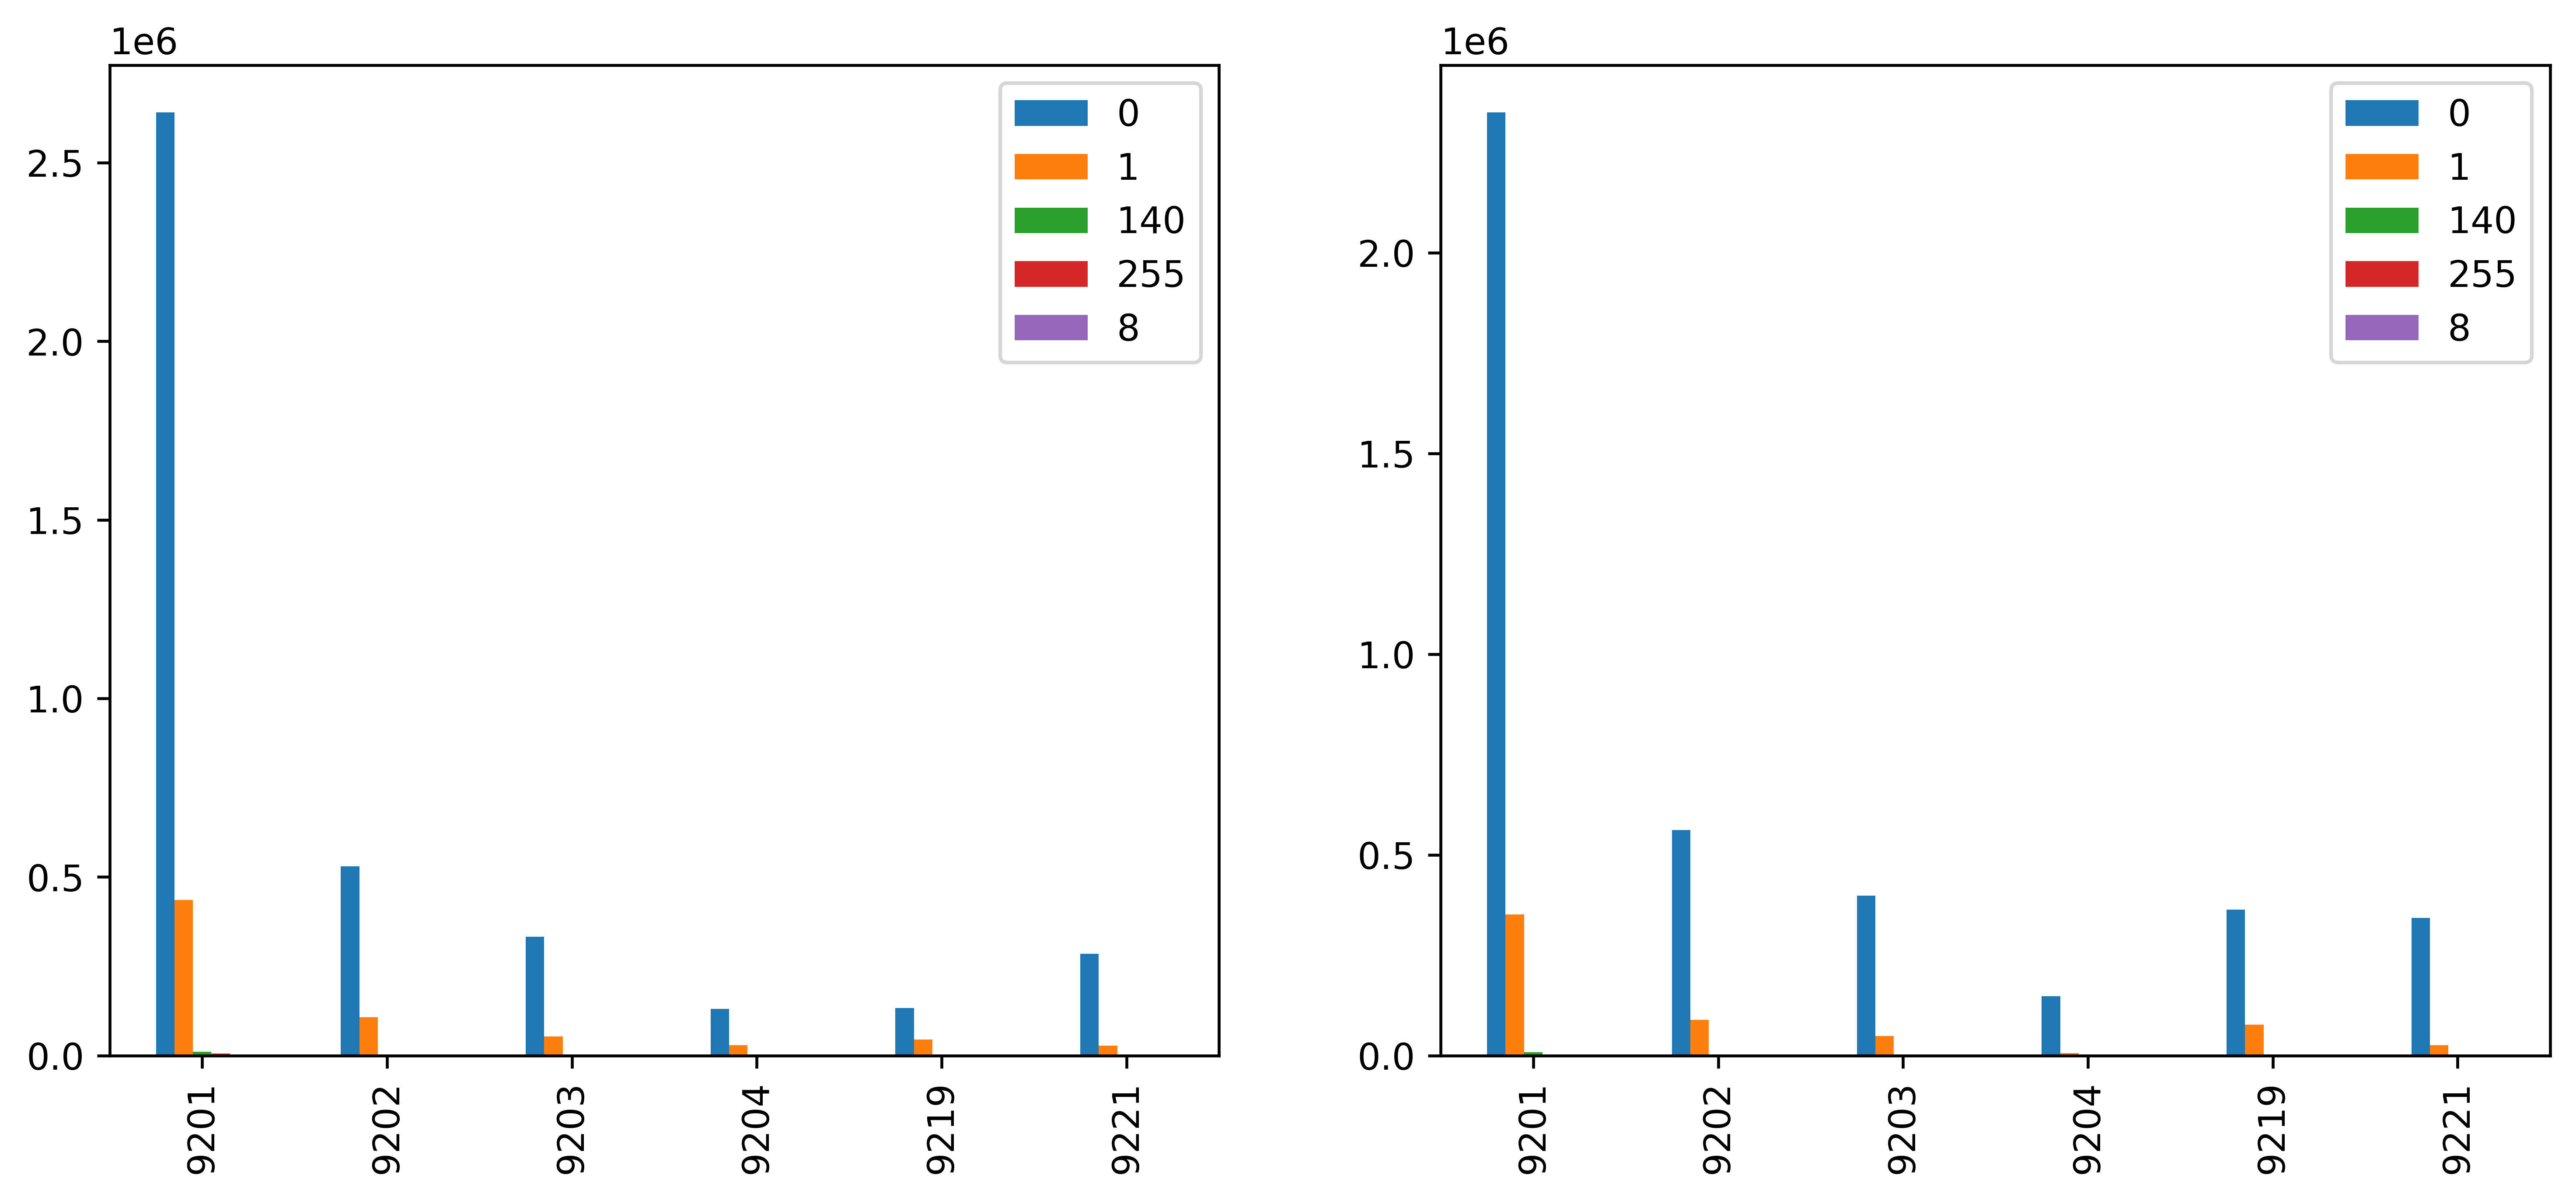

In [38]:
# Perform crosstab on user and returncode columns
ce5_user_returncode_crosstab = ce5_log.crosstab('USER', 'RETURNCODE').toPandas()
ce5_user_returncode_crosstab = ce5_user_returncode_crosstab[~ce5_user_returncode_crosstab['USER_RETURNCODE'].isin(['0','112870'])]
ce6_user_returncode_crosstab = ce6_log.crosstab('USER', 'RETURNCODE').toPandas()

# Plot user/returncode crosstab
fig, axs = plt.subplots(1, 2, figsize = (12, 5), dpi = 600)
ce5_user_returncode_crosstab.sort_values('USER_RETURNCODE').set_index('USER_RETURNCODE').plot.bar(xlabel = '', ax = axs[0])
ce6_user_returncode_crosstab.sort_values('USER_RETURNCODE').set_index('USER_RETURNCODE').plot.bar(xlabel = '', ax = axs[1])
plt.show()

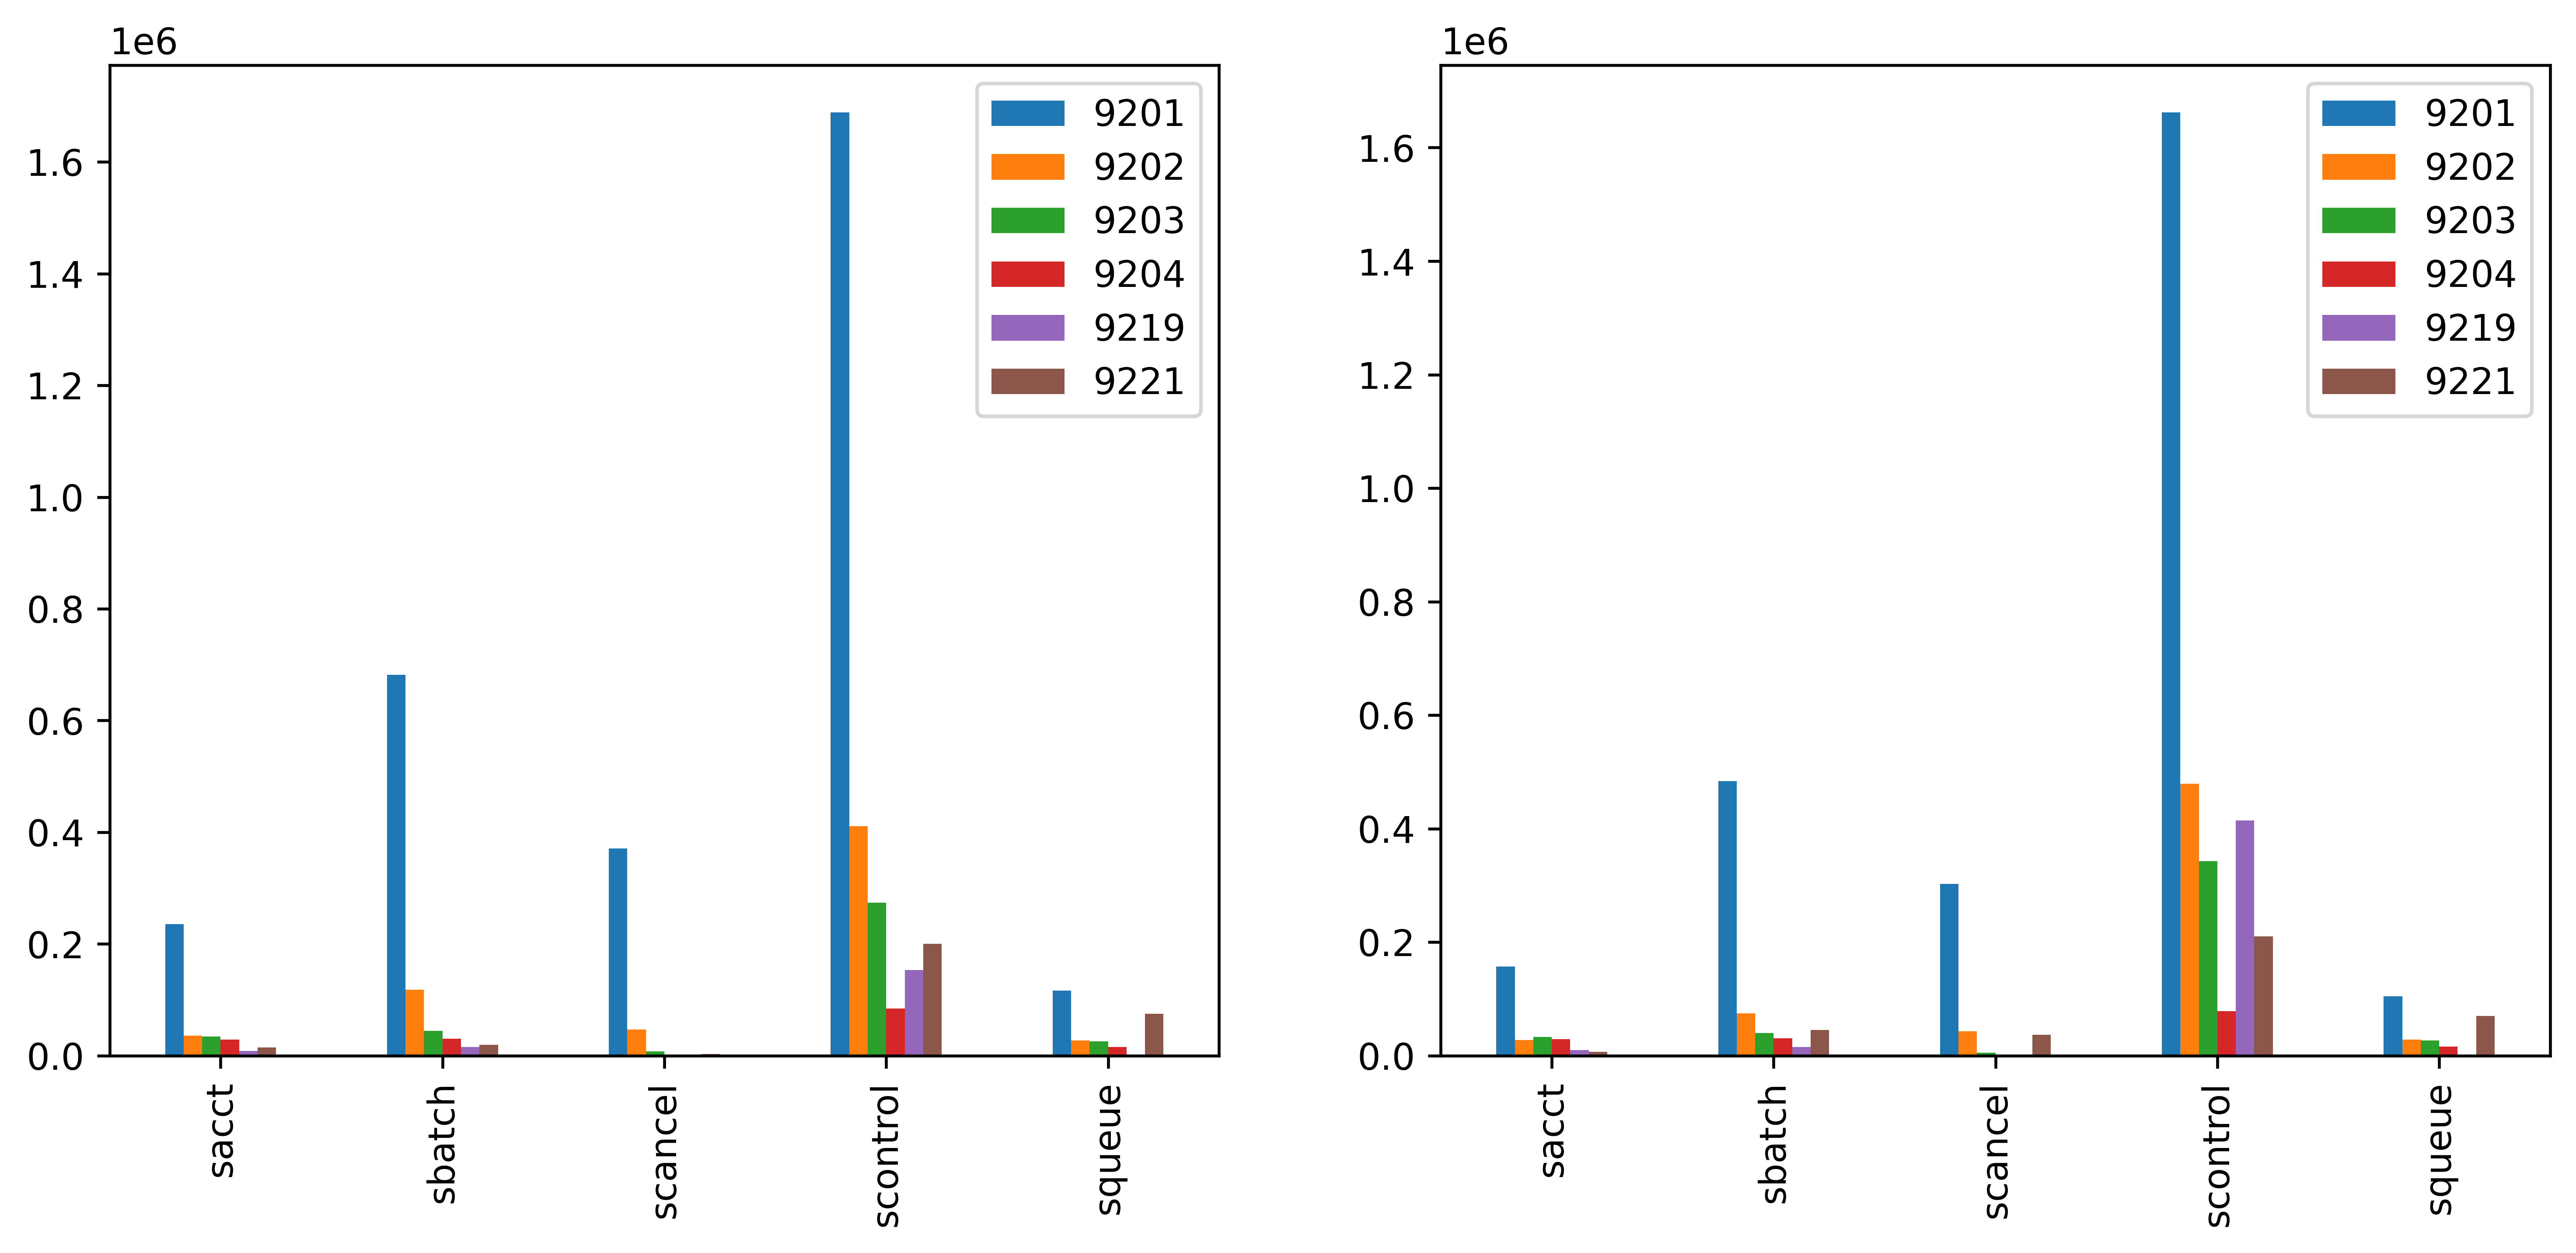

In [37]:
# Perform crosstab on command and user columns
ce5_command_user_crosstab = ce5_log.crosstab('COMMAND', 'USER').toPandas().drop(columns=['0','112870'])
ce6_command_user_crosstab = ce6_log.crosstab('COMMAND', 'USER').toPandas()

# Plot command/user crosstab
fig, axs = plt.subplots(1, 2, figsize = (12, 5), dpi = 600)
ce5_command_user_crosstab.sort_values('COMMAND_USER').set_index('COMMAND_USER').plot.bar(xlabel = '', ax = axs[0])
ce6_command_user_crosstab.sort_values('COMMAND_USER').set_index('COMMAND_USER').plot.bar(xlabel = '', ax = axs[1])
plt.show()

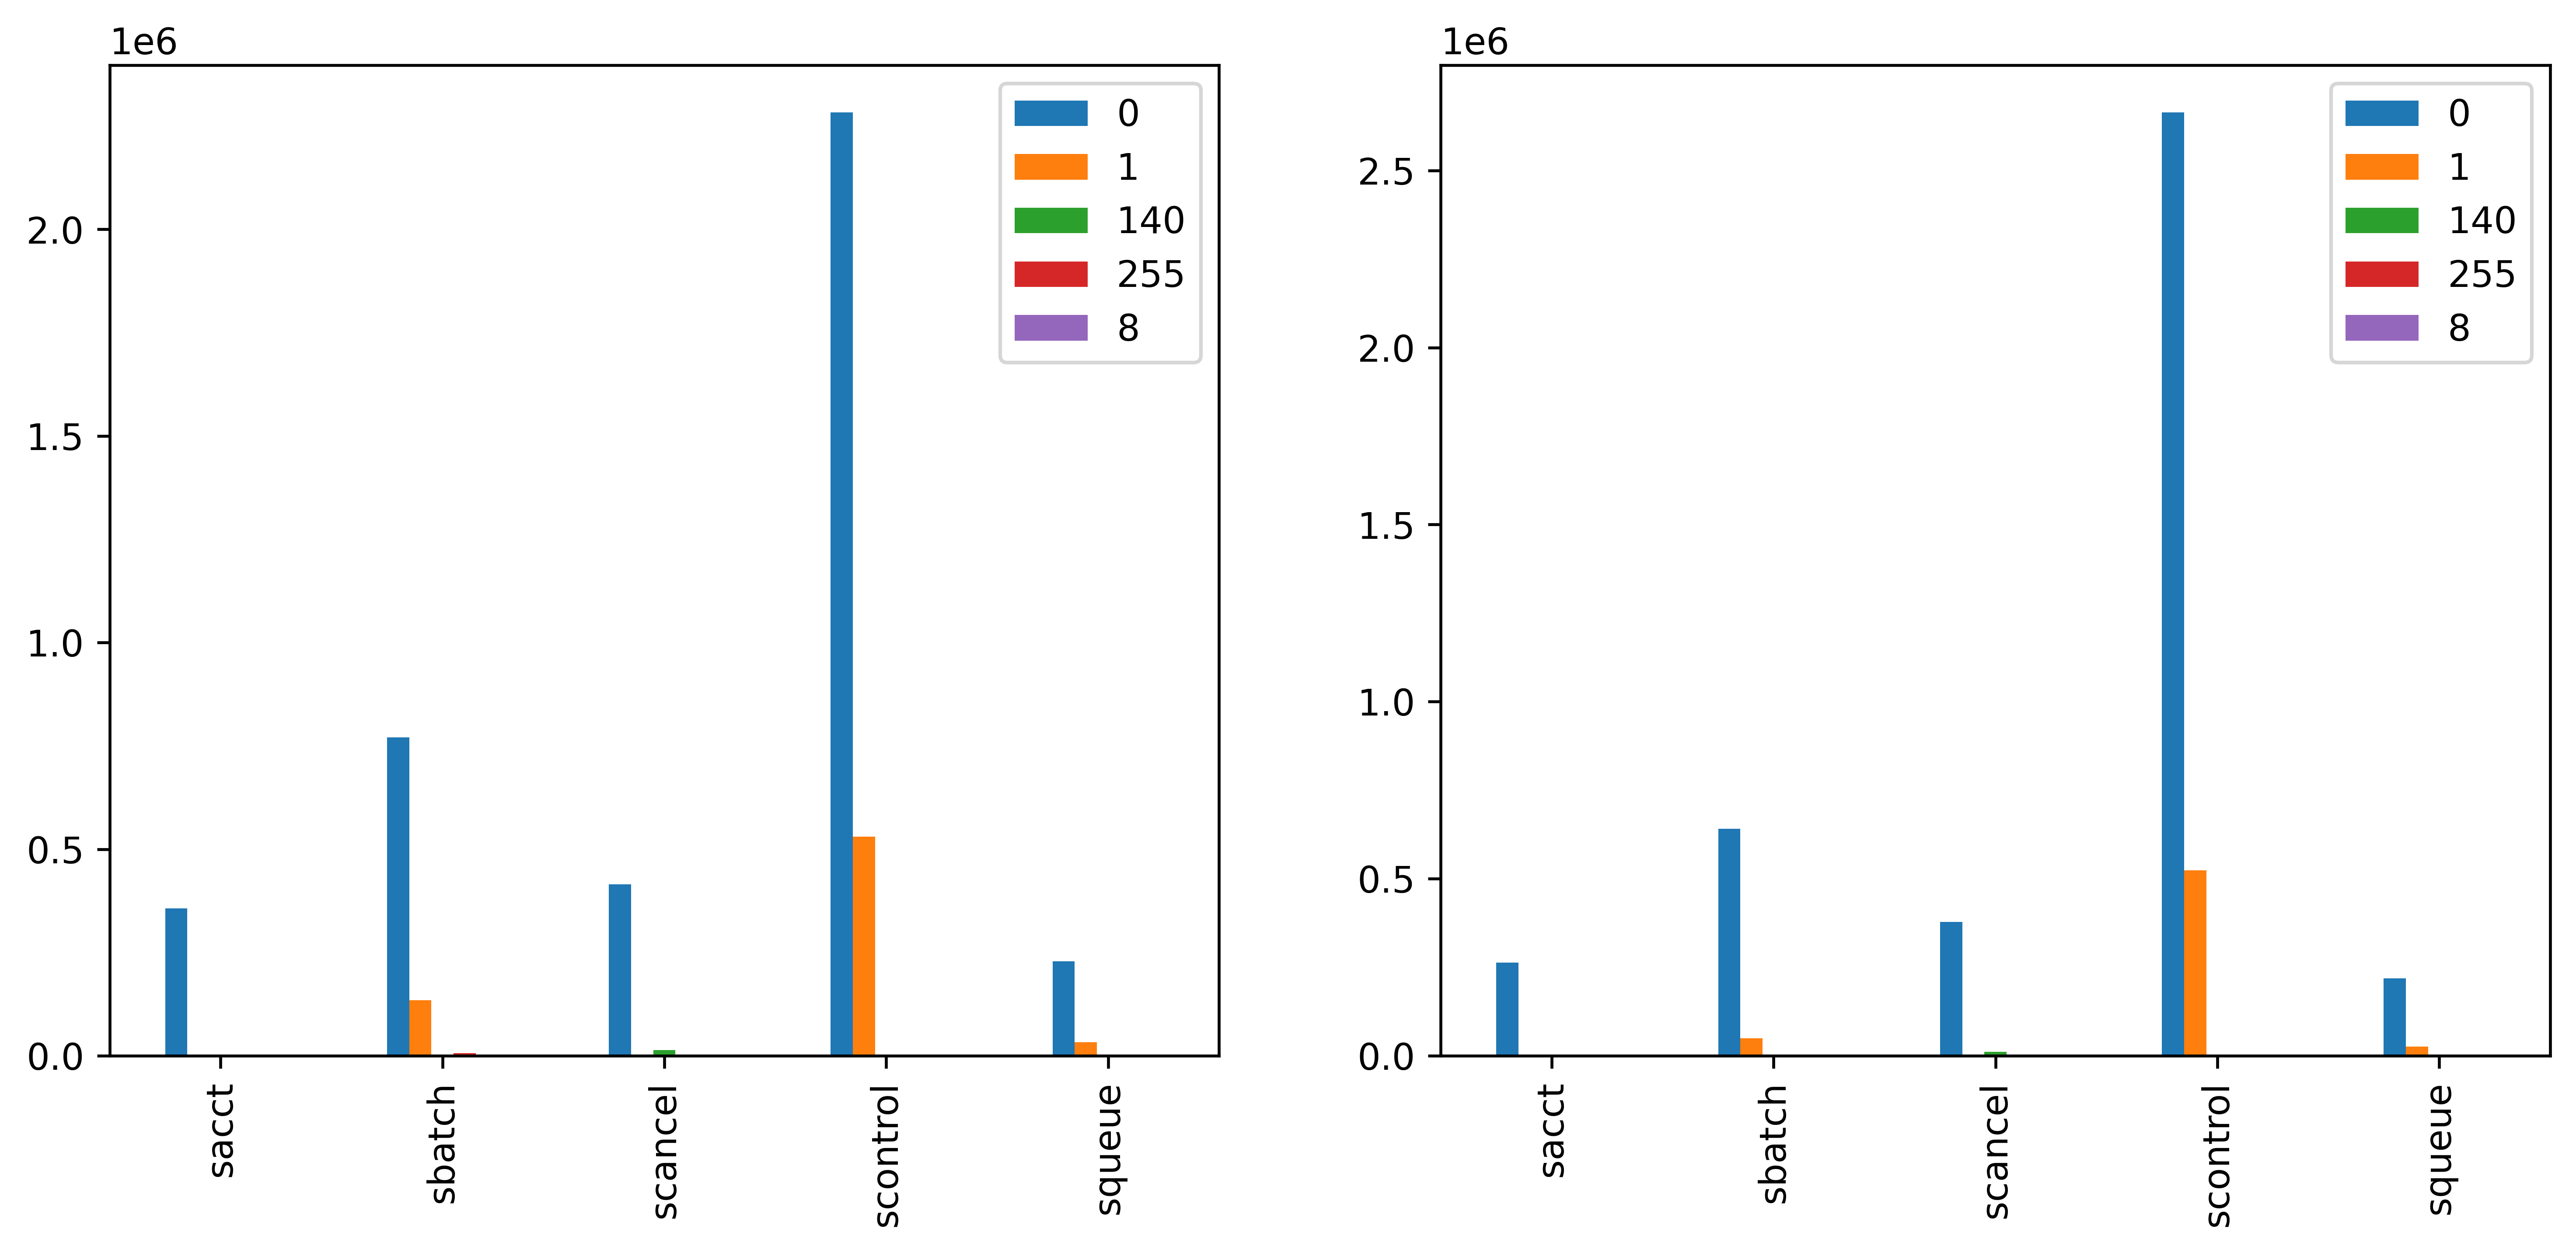

In [39]:
# Perform crosstab on command and returncode columns
ce5_command_returncode_crosstab = ce5_log.crosstab('COMMAND', 'RETURNCODE').toPandas()
ce6_command_returncode_crosstab = ce6_log.crosstab('COMMAND', 'RETURNCODE').toPandas()

# Plot command/returncode crosstab
fig, axs = plt.subplots(1, 2, figsize = (12, 5), dpi = 600)
ce5_command_returncode_crosstab.sort_values('COMMAND_RETURNCODE').set_index('COMMAND_RETURNCODE').plot.bar(xlabel = '', ax = axs[0])
ce6_command_returncode_crosstab.sort_values('COMMAND_RETURNCODE').set_index('COMMAND_RETURNCODE').plot.bar(xlabel = '', ax = axs[1])
plt.show()